# Convert analytic satellite images to 'visible' format
- very very preliminary stage., left in this for now
- notebook code shall eventually be made a .py file

In [1]:
# check whether all are needed
import numpy as np
import pandas as pd
import rasterio 
from rasterio.plot import show
from osgeo import gdal
from scipy import stats
import skimage
from skimage import exposure
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,12)

import hh_utilities as hu

In [2]:
# file name
fn = "/media/hh/hd_internal/_data_DS/DSR/satelliteImages/Borneo/3093/20180427_020348_103a_3B_AnalyticMS.tif"
# open dataset
src = rasterio.open(fn)
# read all data into numpy array (the bands are in the first dimension!)
img_arr = src.read(masked=True)
#img_arr = src.read(masked=False)
mask_arr = src.read_masks()

In [3]:
# this is the preliminary definition of the function
def convert_sat_img(img_arr, mask_arr=None, src_type="BGRN", dest_type=["RGB"], do_visualize=True):
    """
    Converts analytic image (3 or 4 bands) to visual format
    Input args:
    img_arr: numpy array, resulting from rasterio .read() 
    mask_arr: numpy array, resulting from rasterio read_mask()
    src_type: string, bands in source file, any of RGB, RGBA, BGRN 
        (pay attention to order)
        - RGB: normal red green blue image
        - RGBA: RGB with alpha map
        - BGRN: or 4-band image with N=near infrared
    dest_type: string or list of strings, output format, 
        any combination of RGB, PCA, and PCA-IR
        - RGB: normal red green blue image
        - PCA: grayscale image of 1st principal component
        - PCA-IR: first two principal components of RGB bands plus IR channel, so this would be
        some kind of false-color image (highly experimental)       
    do_visualize: boolean, if True, images will be displayed
    """
    pass

In [4]:
# define a few variables = partly input args into function
src_type = "BGRN"
dest_type = ["RGB"] 
do_visualize = True

do_scale_bands_separate = False

In [5]:
# input error checking:
assert(src_type in ("RGB", "RGBA", "BGRN"))
assert(not set(dest_type).difference(set(["RGB", "PCA", "PCA-IR"])))
# ensure that actual and expected number of input bands match
assert(len(src_type)==src.count)

In [6]:
# preparations:
# - dictionary of colors to be used for the visual representation of 
# each band
band_color_rep = {'B': 'blue',
                  'G': 'green',
                  'R': 'red',
                  'N': 'black',
                  'A': None}

# set up dataframe characterizing each band
band_df = pd.DataFrame({"band_index": src.indexes, 
                        "name": list(src_type),
                        "plot_col": [band_color_rep[b] for b in list(src_type)],
                        "dtype": src.dtypes,
                        "maxval": [np.iinfo(t).max for t in src.dtypes],
                        "nodatavals": src.nodatavals,
                       }).set_index("name")

# list of indexes to RGB and N bands, because these bands will be treated
# differently from other bands
rgb_ix = [src_type.find(c) for c in "RGB"]
n_ix = src_type.find("N")

band_df

,band_index,plot_col,dtype,maxval,nodatavals
name,,,,,
B,1,blue,uint16,65535,0.0
G,2,green,uint16,65535,0.0
R,3,red,uint16,65535,0.0
N,4,black,uint16,65535,0.0


In [7]:
np.max(img_arr[0])

33316

[4250, 3613, 2306, 8425]

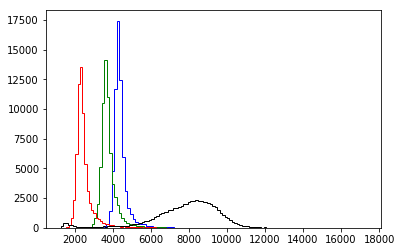

In [8]:
# visualize histograms & compute mode of each band
# determine downsampling factor along each axis depending on image size:
ds_fac = round(((src.width * src.height) // 1e5) ** 0.5)
md = []
for band_ix in range(src.count):
    sub_data = img_arr[band_ix,::ds_fac,::ds_fac].ravel()
    if do_visualize:
        figH1 = plt.figure(1)        
        # § better use scikit hist, could be more efficient on integers
        plt.hist(sub_data,100,histtype='step',
                 color=band_color_rep[src_type[band_ix]])
    if "int" in band_df["dtype"][band_ix]:
        # eliminate zeros for computing mode
        sub_data = sub_data[sub_data>0]
        md.append(stats.mode(sub_data, nan_policy="omit").mode[0])
    else:
        raise Exception("mode not yet impemented for floating point image data")

md    
        

In [10]:
if do_scale_bands_separate:
    pass
else:
    # compute percentile from rgb bands (in their entirety, so we don't cause a color shift)
    prc_rgb = np.percentile(img_arr[rgb_ix,:,:], (99.9,))
prc_rgb

array([7934.])

In [ ]:
# copy rgb bands in rgb order and rescale such that 
# percentile computed above is the new maximum of the number type present
img_arr_rgb = exposure.rescale_intensity(img_arr[rgb_ix,:,:], in_range=(0,prc_rgb[0]))

In [ ]:
# scale to uint8 by doing a bit-wise shift
img_arr_rgb = img_arr_rgb  >> 8

In [ ]:
fig = plt.figure(figsize=(20, 20))
show(img_arr_rgb[:,500:2000,3500:5000])

As satellite images are usually at an oblique angle, there are always many pixels not belonging to the image with a value of src.nodatavals

In [ ]:
# do the same thing for N band if it exists
if (n_ix >= 0):
    prc_n = np.percentile(img_arr[n_ix,:,:], (99.9,))
    img_arr_n = exposure.rescale_intensity(img_arr[n_ix,:,:], in_range=(0, prc_n[0]))
    img_arr_n = img_arr_n  >> 8
    fig = plt.figure(figsize=(20, 20))
    show(img_arr_n[500:2000,3500:5000], cmap="gray")
    

In [ ]:
img_arr_mix = img_arr_rgb
img_arr_mix[1] = img_arr_n

In [ ]:
fig = plt.figure(figsize=(20, 20))
show(img_arr_mix[:,500:2000,3500:5000])

In [ ]:
# taken from the training image generation notebook, has to be adapted
def write_tile(src, window, meta, ax_tile):
    outpath = output_tile_filename.format(TRAINING_SAT_DIR,int(window.col_off),int(window.row_off))
    with rio.open(outpath, 'w', **meta) as outds:
        tile = src.read(window=window)
        rioplot.show(tile, ax=ax_tile, cmap='gray')
        outds.write(tile)

In [ ]:
# convert to floating point
#img_arr = skimage.img_as_float(img_arr)

In [ ]:
whos

In [ ]:
mask_arr[0,0,0]

In [ ]:
np.iinfo(np.uint8).max

In [ ]:
fu = np.uint8
fu(8)

In [ ]:
np.cast